In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
import sklearn
from sklearn.linear_model import LinearRegression
import scienceplots
from postalcodes_ca import fsa_codes
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import inv_boxcox    

plt.style.use('science')
plt.rcParams['text.usetex'] = False

In [2]:
df = pd.read_pickle('delistings_secondary_data.pkl')
df

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,...,Engine_Capacity,Top_Speed,Acceleration,Dimensions_Length,Dimensions_Width,Dimensions_Height,Dimensions_Wheelbase,Cargo_Volume,Unladen_Weight,Fuel_Economy
0,202009,L4A,Private,1955.0,Chevrolet,Corvette,Gasoline,3,Sports_Car,Used,...,15.714286,120.000000,11.400000,4242.000000,1834.0,1323.000000,2591.0,634.000000,1272.000000,32.000000
1,202007,V5X,Private,1955.0,Chevrolet,Corvette,Gasoline,5,Sports_Car,Used,...,15.714286,120.000000,11.400000,4242.000000,1834.0,1323.000000,2591.0,634.000000,1272.000000,32.000000
2,202005,V2P,Private,1955.0,Chevrolet,Corvette,Gasoline,5,Sports_Car,Used,...,15.714286,120.000000,11.400000,4242.000000,1834.0,1323.000000,2591.0,634.000000,1272.000000,32.000000
3,201711,T8A,Private,1955.0,Ford,Thunderbird,NaN,3,Sports_Car,Used,...,15.714286,126.000000,9.081818,4458.000000,1750.0,1308.000000,2591.0,464.000000,1555.000000,32.000000
4,202008,L3B,Private,1955.0,Ford,Thunderbird,Gasoline,3,Sports_Car,Used,...,15.714286,126.000000,9.081818,4458.000000,1750.0,1308.000000,2591.0,464.000000,1555.000000,32.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2354658,201807,J2H,Private,2008.0,Hyundai,Genesis,Gasoline,0,Sedan,Used,...,19.915385,139.333333,6.566667,4763.076923,1874.0,1419.384615,2864.0,347.230769,1626.692308,21.269231
2354659,202101,T2A,Private,2008.0,Hyundai,Genesis,NaN,0,NaN,Used,...,19.915385,139.333333,6.566667,4763.076923,1874.0,1419.384615,2864.0,347.230769,1626.692308,21.269231
2354660,201903,P7J,Private,2008.0,Hyundai,Genesis,Gasoline,0,Sports_Car,Used,...,19.915385,139.333333,6.566667,4763.076923,1874.0,1419.384615,2864.0,347.230769,1626.692308,21.269231
2354677,201902,N6B,Private,2011.0,Toyota,Hilux,Gasoline,2,Truck,Used,...,15.714286,106.000000,13.575000,5260.000000,1834.0,1849.000000,3086.0,464.000000,1862.500000,32.200000


In [3]:
df['yr_month_dtype'] = pd.to_datetime(df['yr_month'], format='%Y%m')
df['yr_month_dtype']

0         2020-09-01
1         2020-07-01
2         2020-05-01
3         2017-11-01
4         2020-08-01
             ...    
2354658   2018-07-01
2354659   2021-01-01
2354660   2019-03-01
2354677   2019-02-01
2354739   2023-10-01
Name: yr_month_dtype, Length: 2974606, dtype: datetime64[ns]

In [4]:
df['yr_month_dtype'].sort_values()

572724    2016-01-01
319335    2016-01-01
623671    2016-01-01
623679    2016-01-01
71999     2016-01-01
             ...    
2597919   2024-03-01
1356369   2024-03-01
367757    2024-03-01
2598155   2024-03-01
2625432   2024-03-01
Name: yr_month_dtype, Length: 2974606, dtype: datetime64[ns]

In [5]:
df['age'] = df['yr_month_dtype'].dt.year + (df['yr_month_dtype'].dt.month)/12 - df['year']
df['age'] = np.where(df['age'] < 0, 0, df['age'])
df['age']

0          65.750000
1          65.583333
2          65.416667
3          62.916667
4          65.666667
             ...    
2354658    10.583333
2354659    13.083333
2354660    11.250000
2354677     8.166667
2354739    15.833333
Name: age, Length: 2974606, dtype: float64

In [6]:
list_cols_created_expanded = ['Engine_Displacement_Cleaned', 'Engine_Torque_Cleaned', 
                     'Engine_Capacity', 'Top_Speed', 'Acceleration', 'Dimensions_Length', 
                     'Dimensions_Width', 'Dimensions_Wheelbase', 'Cargo_Volume', 'Unladen_Weight', 'Fuel_Economy', 'age'
                     ]

In [7]:
# standardize variables in list_cols_created
scaler = StandardScaler()

df_used = df.loc[df['condition'] == 'Used']

df_used[list_cols_created_expanded] = scaler.fit_transform(df_used[list_cols_created_expanded])

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_8608\2920027809.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_used[list_cols_created_expanded] = scaler.fit_transform(df_used[list_cols_created_expanded])


Seeing evolution of average attributes of sales

In [29]:
grouped_df = df.loc[(df['condition'] == 'Used')&(df['yr_month_dtype'] >= '2022-06-01')].groupby('yr_month_dtype')[list_cols_created_expanded].mean()
grouped_df

,Engine_Displacement_Cleaned,Engine_Torque_Cleaned,Engine_Capacity,Top_Speed,Acceleration,Dimensions_Length,Dimensions_Width,Dimensions_Wheelbase,Cargo_Volume,Unladen_Weight,Fuel_Economy,age
yr_month_dtype,,,,,,,,,,,,
2022-06-01,2452.100410,270.248031,16.105430,130.037652,8.679433,4695.864405,5537.530921,3052.563344,560.446016,1633.575645,33.933501,6.511965
2022-07-01,2485.967049,254.326961,16.184161,130.292799,8.618733,4693.781506,4757.817983,3060.060581,565.658785,1648.759827,33.734007,6.579398
2022-08-01,2484.002716,280.973712,16.187901,130.373883,8.600035,4701.087033,4597.479463,3045.526423,561.725460,1647.012531,33.784357,6.685535
2022-09-01,2456.045048,352.051609,16.214489,129.980524,8.657703,4697.661931,5510.220323,3126.324553,559.206225,1645.798662,33.740500,6.772224
2022-10-01,2457.201573,282.429284,16.211895,129.939615,8.648478,4704.669478,5170.269229,3038.334542,563.770491,1646.274749,33.730289,6.792090
2022-11-01,2410.188754,290.992673,16.133456,129.362499,8.699440,4678.541711,5340.864834,3120.275255,563.542878,1640.145811,33.934081,6.716589
2022-12-01,2390.835368,262.271183,16.089602,129.256614,8.724575,4681.219837,6043.225498,3061.102663,565.169232,1639.276608,34.118807,6.765979
2023-01-01,2388.185066,268.880382,16.139289,129.125832,8.732580,4683.115892,4964.418777,3037.277631,563.570370,1640.241470,34.147365,6.567430
2023-02-01,2374.034283,248.879641,16.054486,129.209452,8.703682,4698.082370,6005.930082,3136.665897,567.250163,1645.127334,34.110619,6.326718


In [30]:
# Normalize by June 2022
grouped_df = grouped_df.div(grouped_df.loc['2022-06-01']).multiply(100)

<Axes: xlabel='yr_month_dtype'>

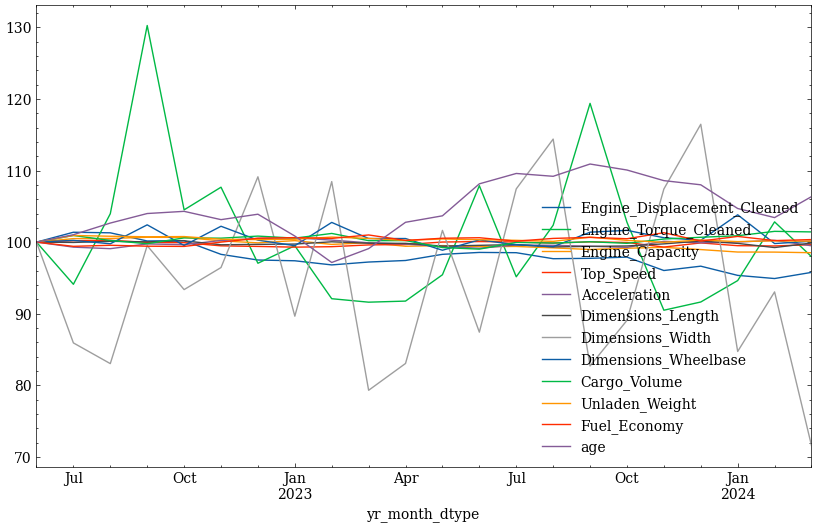

In [31]:
grouped_df.plot(figsize=(10, 6))

<Axes: xlabel='yr_month_dtype'>

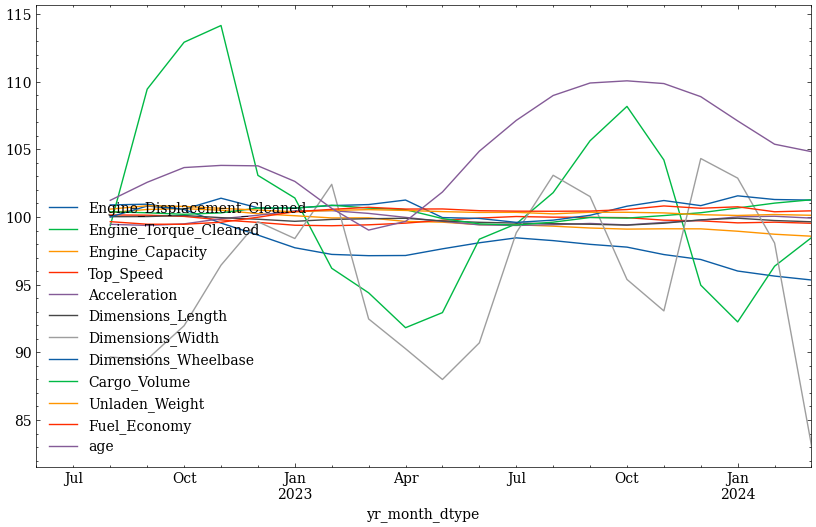

In [32]:
# 3 month moving average
grouped_df.rolling(window=3).mean().plot(figsize=(10, 6))

<Axes: xlabel='yr_month_dtype'>

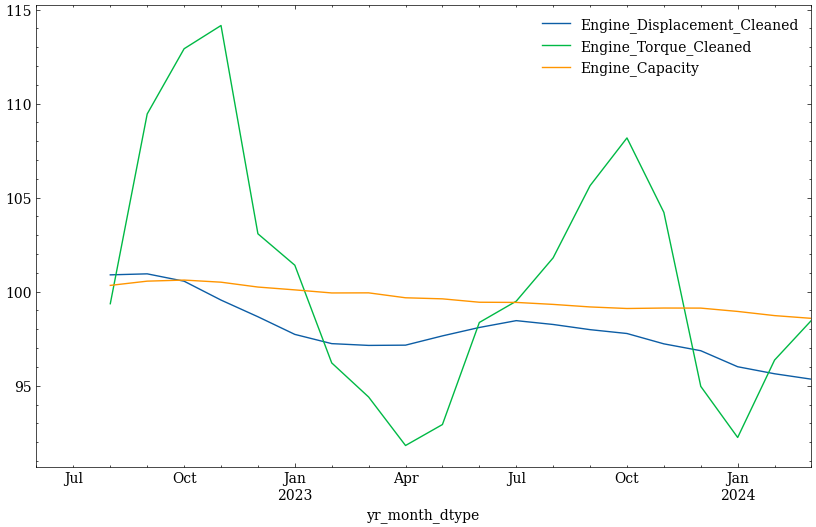

In [33]:
# Plot first 3 variables, 3 month moving average
grouped_df[['Engine_Displacement_Cleaned', 'Engine_Torque_Cleaned', 'Engine_Capacity']].rolling(window=3).mean().plot(figsize=(10, 6))

<Axes: xlabel='yr_month_dtype'>

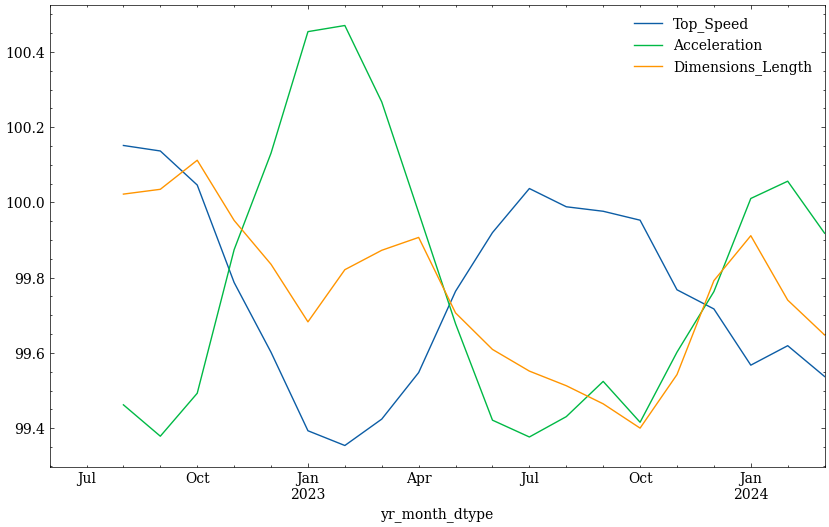

In [34]:
# Plot next 3 variables, 3 month moving average
grouped_df[['Top_Speed', 'Acceleration', 'Dimensions_Length']].rolling(window=3).mean().plot(figsize=(10, 6))

It's really hard to see anything from these graphs so I'll try multiplying everything by the regression coeffs. 

In [35]:
reg4_summary = pd.read_excel('reg4_summary.xlsx', index_col=0)

reg4_summary.columns = reg4_summary.iloc[0]
reg4_summary = reg4_summary[1:]
# rename first column as Variable
reg4_summary = reg4_summary.rename_axis(None, axis=1)
reg4_summary = reg4_summary.rename(columns={np.nan: 'Variable'})
reg4_summary = reg4_summary.set_index("Variable").astype(float)
reg4_summary

,coef,std err,t,P>|t|,[0.025,0.975]
Variable,,,,,,
const,10.0132,0.002,4976.891,0.0,10.009,10.017
Engine_Displacement_Cleaned,0.1188,0.001,135.468,0.0,0.117,0.121
Engine_Torque_Cleaned,0.0976,0.001,110.938,0.0,0.096,0.099
Engine_Capacity,-0.0484,0.001,-83.841,0.0,-0.050,-0.047
Top_Speed,-0.0211,0.001,-28.628,0.0,-0.023,-0.020
...,...,...,...,...,...,...
make_smart,-0.6972,0.010,-70.687,0.0,-0.717,-0.678
make_subaru,0.0740,0.003,28.825,0.0,0.069,0.079
make_suzuki,-0.3002,0.019,-15.672,0.0,-0.338,-0.263


In [36]:
reg4_summary.loc[list_cols_created_expanded, 'coef']

Variable
Engine_Displacement_Cleaned    0.1188
Engine_Torque_Cleaned          0.0976
Engine_Capacity               -0.0484
Top_Speed                     -0.0211
Acceleration                  -0.0097
Dimensions_Length              0.0653
Dimensions_Width               0.0608
Dimensions_Wheelbase           0.0054
Cargo_Volume                  -0.0294
Unladen_Weight                -0.0252
Fuel_Economy                   0.0282
age                           -0.3603
Name: coef, dtype: float64

In [37]:
grouped_df_used_post_june = df_used.loc[(df_used['yr_month_dtype'] >= '2022-06-01')].groupby('yr_month_dtype')[list_cols_created_expanded].mean()
grouped_df_used_post_june

,Engine_Displacement_Cleaned,Engine_Torque_Cleaned,Engine_Capacity,Top_Speed,Acceleration,Dimensions_Length,Dimensions_Width,Dimensions_Wheelbase,Cargo_Volume,Unladen_Weight,Fuel_Economy,age
yr_month_dtype,,,,,,,,,,,,
2022-06-01,0.004193,-0.001255,0.024322,0.061472,-0.082743,0.021538,-0.006850,-0.013596,0.041279,0.137172,0.019560,0.012887
2022-07-01,0.037135,-0.005770,0.044430,0.076398,-0.107105,0.020084,-0.012521,-0.012114,0.057246,0.183136,0.005390,0.026248
2022-08-01,0.035224,0.001787,0.045386,0.081141,-0.114609,0.025183,-0.013687,-0.014987,0.045198,0.177847,0.008967,0.047278
2022-09-01,0.008030,0.021946,0.052177,0.058130,-0.091464,0.022792,-0.007049,0.000981,0.037481,0.174172,0.005852,0.064455
2022-10-01,0.009155,0.002200,0.051514,0.055737,-0.095167,0.027684,-0.009521,-0.016408,0.051462,0.175613,0.005126,0.068391
2022-11-01,-0.036574,0.004629,0.031480,0.021976,-0.074713,0.009446,-0.008281,-0.000214,0.050765,0.157060,0.019601,0.053431
2022-12-01,-0.055399,-0.003517,0.020279,0.015782,-0.064625,0.011315,-0.003173,-0.011908,0.055746,0.154429,0.032722,0.063217
2023-01-01,-0.057977,-0.001643,0.032970,0.008131,-0.061412,0.012639,-0.011018,-0.016617,0.050849,0.157350,0.034750,0.023877
2023-02-01,-0.071742,-0.007315,0.011311,0.013023,-0.073010,0.023086,-0.003444,0.003025,0.062120,0.172140,0.032140,-0.023818


In [38]:
valuation = grouped_df_used_post_june @ reg4_summary.loc[list_cols_created_expanded, 'coef'] + reg4_summary.loc['const', 'coef']
valuation

yr_month_dtype
2022-06-01    10.004059
2022-07-01     9.999206
2022-08-01     9.992901
2022-09-01     9.985947
2022-10-01     9.982461
2022-11-01     9.984007
2022-12-01     9.978684
2023-01-01     9.991963
2023-02-01    10.008487
2023-03-01     9.999686
2023-04-01     9.984058
2023-05-01     9.981963
2023-06-01     9.963347
2023-07-01     9.955444
2023-08-01     9.956048
2023-09-01     9.948440
2023-10-01     9.952257
2023-11-01     9.955067
2023-12-01     9.959084
2024-01-01     9.971563
2024-02-01     9.974831
2024-03-01     9.964462
dtype: float64

<Axes: xlabel='yr_month_dtype'>

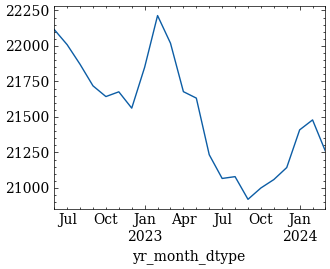

In [39]:
np.exp(valuation).plot()

Text(0, 0.5, "Valuation of 'Quality' Attributes (CAD)")

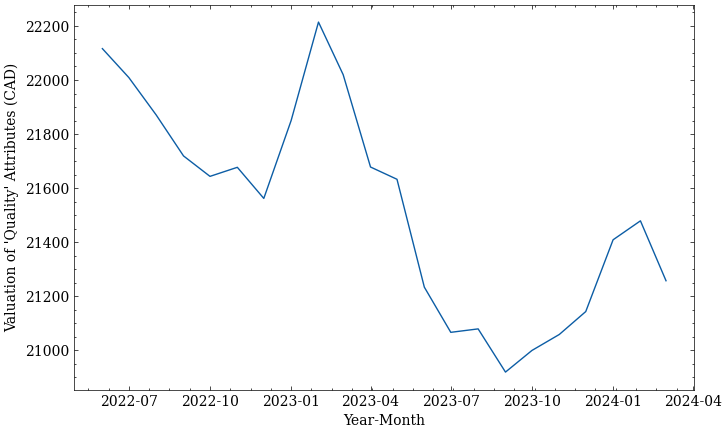

In [40]:
plt.figure(figsize=(8, 5)) 
plt.plot(np.exp(valuation))
plt.xlabel('Year-Month')
plt.ylabel("Valuation of 'Quality' Attributes (CAD)")

Valuations for the entire period


In [41]:
grouped_df_all = df_used.groupby('yr_month_dtype')[list_cols_created_expanded].mean()
grouped_df_all

,Engine_Displacement_Cleaned,Engine_Torque_Cleaned,Engine_Capacity,Top_Speed,Acceleration,Dimensions_Length,Dimensions_Width,Dimensions_Wheelbase,Cargo_Volume,Unladen_Weight,Fuel_Economy,age
yr_month_dtype,,,,,,,,,,,,
2016-01-01,0.067121,-0.011143,-0.004253,-0.051129,0.083631,-0.028833,0.018056,-0.077905,-0.044112,-0.150592,-0.116058,-0.064581
2016-02-01,0.073977,-0.000213,-0.010895,-0.028783,0.068914,-0.030235,0.004585,-0.078893,-0.041647,-0.149342,-0.100400,-0.108676
2016-03-01,0.058682,-0.002341,-0.021345,-0.016148,0.067403,-0.035073,0.005181,-0.076133,-0.053485,-0.164799,-0.093871,-0.098733
2016-04-01,0.084836,0.000340,-0.011210,0.002919,0.064384,-0.032467,0.004778,-0.069732,-0.063432,-0.149574,-0.093200,-0.091442
2016-05-01,0.085546,0.009678,-0.014509,0.015584,0.056154,-0.034828,0.005373,-0.059841,-0.075024,-0.152766,-0.082141,-0.080855
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,-0.090420,-0.008548,-0.005661,0.009064,-0.078786,0.013526,-0.003860,-0.009883,0.048720,0.135745,0.051302,0.123764
2023-12-01,-0.075952,-0.007667,-0.018457,0.053034,-0.086030,0.026669,-0.000218,-0.012031,0.052931,0.151971,0.023164,0.116249
2024-01-01,-0.106636,-0.005374,-0.032602,0.023600,-0.082299,0.015734,-0.013003,0.009447,0.056634,0.140807,0.038789,0.073524


In [42]:
valuation_all = grouped_df_all @ reg4_summary.loc[list_cols_created_expanded, 'coef'] + reg4_summary.loc['const', 'coef']
valuation_all

yr_month_dtype
2016-01-01    10.044442
2016-02-01    10.061625
2016-03-01    10.056928
2016-04-01    10.056915
2016-05-01    10.054736
                ...    
2023-11-01     9.955067
2023-12-01     9.959084
2024-01-01     9.971563
2024-02-01     9.974831
2024-03-01     9.964462
Length: 99, dtype: float64

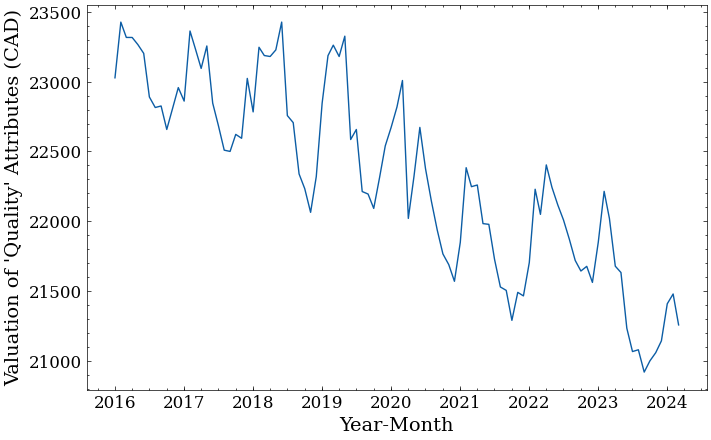

In [43]:
plt.figure(figsize=(8, 5)) 
plt.plot(np.exp(valuation_all))
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Year-Month', size=14)
plt.ylabel("Valuation of 'Quality' Attributes (CAD)", size=14)
plt.show()

Effect of coefficients

In [26]:
np.exp(reg4_summary.loc[list_cols_created_expanded, 'coef']) - 1

Variable
Engine_Displacement_Cleaned    0.126145
Engine_Torque_Cleaned          0.102522
Engine_Capacity               -0.047247
Top_Speed                     -0.020879
Acceleration                  -0.009653
Dimensions_Length              0.067479
Dimensions_Width               0.062686
Dimensions_Wheelbase           0.005415
Cargo_Volume                  -0.028972
Unladen_Weight                -0.024885
Fuel_Economy                   0.028601
age                           -0.302533
Name: coef, dtype: float64

Valuations of new cars

In [24]:
df_new = df.loc[df['condition'] == 'New'].copy()

# standardize variables in list_cols_created
scaler = StandardScaler()

df_new[list_cols_created_expanded] = scaler.fit_transform(df_new[list_cols_created_expanded])


In [25]:
grouped_df_all_new = df_new.groupby('yr_month_dtype')[list_cols_created_expanded].mean()
grouped_df_all_new

,Engine_Displacement_Cleaned,Engine_Torque_Cleaned,Engine_Capacity,Top_Speed,Acceleration,Dimensions_Length,Dimensions_Width,Dimensions_Wheelbase,Cargo_Volume,Unladen_Weight,Fuel_Economy,age
yr_month_dtype,,,,,,,,,,,,
2016-01-01,-0.029359,-0.208713,-0.100211,-0.053564,0.114876,0.004128,-0.042070,0.527389,-0.122537,-0.100887,0.045503,-0.173774
2016-02-01,-0.055752,-0.224377,-0.116369,-0.015590,0.095190,-0.005919,-0.042107,0.462289,-0.172772,-0.153902,0.033573,-0.151985
2016-03-01,-0.049595,-0.216130,-0.095238,-0.011583,0.046960,-0.029260,-0.042329,0.383279,-0.195383,-0.191158,0.022920,-0.089619
2016-04-01,-0.042804,-0.195527,-0.086254,0.001931,0.019448,-0.023757,0.007040,0.397055,-0.228974,-0.213345,0.057669,-0.064762
2016-05-01,-0.034829,-0.195472,-0.087384,-0.005321,-0.005682,-0.035923,-0.042204,0.479387,-0.242411,-0.231987,0.028034,-0.017692
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,0.133921,0.326282,-0.087245,0.169228,-0.254745,-0.064990,-0.041976,-0.087867,-0.197553,-0.126686,-0.117641,-0.372172
2023-12-01,0.176118,0.384016,-0.048128,0.218234,-0.296494,-0.054480,-0.042255,-0.086223,-0.219213,-0.104514,-0.118119,-0.363653
2024-01-01,0.120321,0.275786,-0.098305,0.165114,-0.242396,-0.065071,-0.042454,-0.087302,-0.212228,-0.181391,-0.115252,-0.361881


In [26]:
reg3_summary = pd.read_excel('reg3_summary_23_07.xlsx', index_col=0)

reg3_summary.columns = reg3_summary.iloc[0]
reg3_summary = reg3_summary[1:]
# rename first column as Variable
reg3_summary = reg3_summary.rename_axis(None, axis=1)
reg3_summary = reg3_summary.rename(columns={np.nan: 'Variable'})
reg3_summary = reg3_summary.set_index("Variable").astype(float)
reg3_summary

,coef,std err,t,P>|t|,[0.025,0.975]
Variable,,,,,,
const,47980.0000,166.014,288.983,0.0,47600.000,48300.000
Engine_Displacement_Cleaned,3962.2222,54.385,72.855,0.0,3855.629,4068.816
Engine_Torque_Cleaned,4280.1553,61.141,70.005,0.0,4160.321,4399.989
Engine_Capacity,2732.9541,49.590,55.112,0.0,2635.760,2830.148
Top_Speed,-553.8072,48.202,-11.489,0.0,-648.282,-459.332
...,...,...,...,...,...,...
make_porsche,64150.0000,415.363,154.455,0.0,63300.000,65000.000
make_smart,-10520.0000,1655.462,-6.354,0.0,-13800.000,-7273.875
make_subaru,-1641.5298,198.207,-8.282,0.0,-2030.009,-1253.050


In [27]:
valuation_new = grouped_df_all_new @ reg3_summary.loc[list_cols_created_expanded, 'coef'] + reg3_summary.loc['const', 'coef']
valuation_new

yr_month_dtype
2016-01-01    47274.623858
2016-02-01    46978.360658
2016-03-01    46818.098724
2016-04-01    46991.986812
2016-05-01    46718.580010
                  ...     
2023-11-01    49942.721487
2023-12-01    50408.492723
2024-01-01    49669.970653
2024-02-01    49364.510264
2024-03-01    46074.107221
Length: 99, dtype: float64

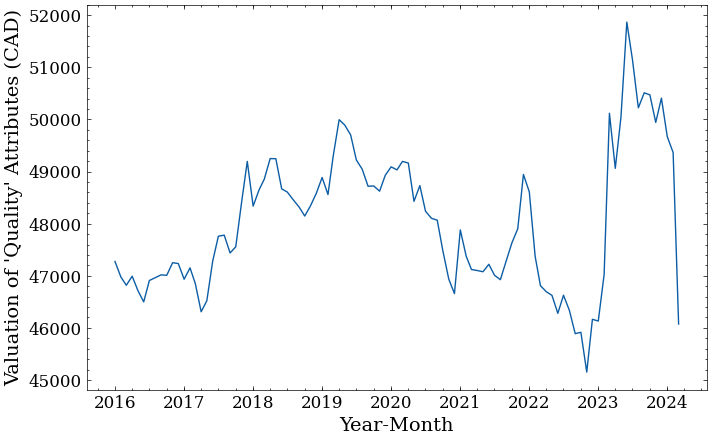

In [28]:
plt.figure(figsize=(8, 5)) 
plt.plot(valuation_new)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Year-Month', size=14)
plt.ylabel("Valuation of 'Quality' Attributes (CAD)", size=14)
plt.show()